<a href="https://colab.research.google.com/github/jjome/dl_cg/blob/master/cycleGAN_model1_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision pillow numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

### Colab 마운트

In [ ]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# FOLDERNAME = 'test'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# import sys
# sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# # Change directory to current folder
# %cd /content/drive/MyDrive/$FOLDERNAME

In [2]:
!git clone https://github.com/jjome/dl_cg.git

Cloning into 'dl_cg'...
remote: Enumerating objects: 4240, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 4240 (delta 5), reused 10 (delta 1), pack-reused 4218
Receiving objects: 100% (4240/4240), 99.64 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (8442/8442), done.


필요한 라이브러리 import

In [3]:
import os
import shutil
import itertools
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

### 사진 파일 불러오기

'dataset' 파일 안에 'older' 파일과 'younger' 파일이 있는 형태여야 함

In [4]:
# Define the base directories
target_dir = '/content/dl_cg/dataset4'
older_dir = os.path.join(target_dir, 'older')
younger_dir = os.path.join(target_dir, 'younger')

### transformations, dataloaders, batch size

In [5]:
# Step 3: Run the PyTorch code
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    #transforms.RandomRotation(degrees=10),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define dataset and dataloaders
older_dataset = datasets.ImageFolder(root=older_dir, transform=transform)
younger_dataset = datasets.ImageFolder(root=younger_dir, transform=transform)

# Ensure drop_last=True to handle incomplete batches
batch_size = 32
older_dataloader = DataLoader(older_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
younger_dataloader = DataLoader(younger_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

# Example: Print first few images to verify
older_img, older_label = next(iter(older_dataloader))
younger_img, younger_label = next(iter(younger_dataloader))

print("Shape of older image batch:", older_img.shape)
print("Shape of younger image batch:", younger_img.shape)

Shape of older image batch: torch.Size([32, 3, 256, 256])
Shape of younger image batch: torch.Size([32, 3, 256, 256])


### generator, discriminator

In [6]:
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


### cycleGAN 정의하기

In [7]:
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.G_XtoY = Generator()
        self.G_YtoX = Generator()
        self.D_X = Discriminator()
        self.D_Y = Discriminator()

    def forward(self):
        pass

# Instantiate the model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycle_gan = CycleGAN().to(device)
print(device)


cuda


### loss function, optimizer

In [8]:
import itertools
import torch.optim as optim

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(cycle_gan.G_XtoY.parameters(), cycle_gan.G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(cycle_gan.D_X.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(cycle_gan.D_Y.parameters(), lr=0.0001, betas=(0.5, 0.999))


### model training

In [9]:
# Training loop
# num_epochs = 100
num_epochs = 5
for epoch in range(num_epochs):
    for i, (data_X, data_Y) in enumerate(zip(older_dataloader, younger_dataloader)):
        # Get real images
        real_X = data_X[0].to(device)
        real_Y = data_Y[0].to(device)

        # Adversarial ground truths with the same shape as discriminator outputs
        valid = torch.ones(real_X.size(0), 1, 15, 15, dtype=torch.float, requires_grad=False).to(device)
        fake = torch.zeros(real_X.size(0), 1, 15, 15, dtype=torch.float, requires_grad=False).to(device)

        # ----------------------
        #  Train Generators
        # ----------------------

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_X = criterion_identity(cycle_gan.G_YtoX(real_X), real_X)
        loss_id_Y = criterion_identity(cycle_gan.G_XtoY(real_Y), real_Y)

        loss_identity = (loss_id_X + loss_id_Y) / 2

        # GAN loss
        fake_Y = cycle_gan.G_XtoY(real_X)
        loss_GAN_XtoY = criterion_GAN(cycle_gan.D_Y(fake_Y), valid)

        fake_X = cycle_gan.G_YtoX(real_Y)
        loss_GAN_YtoX = criterion_GAN(cycle_gan.D_X(fake_X), valid)

        loss_GAN = (loss_GAN_XtoY + loss_GAN_YtoX) / 2

        # Cycle loss
        recov_X = cycle_gan.G_YtoX(fake_Y)
        loss_cycle_X = criterion_cycle(recov_X, real_X)

        recov_Y = cycle_gan.G_XtoY(fake_X)
        loss_cycle_Y = criterion_cycle(recov_Y, real_Y)

        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

        # Total loss
        loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # Adjust output range of generated images
        fake_Y = (fake_Y + 1) / 2  # Map from [-1, 1] to [0, 1]
        fake_X = (fake_X + 1) / 2  # Map from [-1, 1] to [0, 1]

        # ----------------------
        #  Train Discriminators
        # ----------------------

        # Discriminator X
        optimizer_D_X.zero_grad()

        loss_real_X = criterion_GAN(cycle_gan.D_X(real_X), valid)
        loss_fake_X = criterion_GAN(cycle_gan.D_X(fake_X.detach()), fake)

        loss_D_X = (loss_real_X + loss_fake_X) / 2

        loss_D_X.backward()
        optimizer_D_X.step()

        # Discriminator Y
        optimizer_D_Y.zero_grad()

        loss_real_Y = criterion_GAN(cycle_gan.D_Y(real_Y), valid)
        loss_fake_Y = criterion_GAN(cycle_gan.D_Y(fake_Y.detach()), fake)

        loss_D_Y = (loss_real_Y + loss_fake_Y) / 2

        loss_D_Y.backward()
        optimizer_D_Y.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(older_dataloader)}] "
              f"[D loss: {loss_D_X.item() + loss_D_Y.item()}] [G loss: {loss_G.item()}]")


[Epoch 0/5] [Batch 0/66] [D loss: 0.5155266225337982] [G loss: 14.060577392578125]
[Epoch 0/5] [Batch 1/66] [D loss: 0.4312905967235565] [G loss: 12.96038818359375]
[Epoch 0/5] [Batch 2/66] [D loss: 0.3683348596096039] [G loss: 11.619854927062988]
[Epoch 0/5] [Batch 3/66] [D loss: 0.32795262336730957] [G loss: 10.48612117767334]
[Epoch 0/5] [Batch 4/66] [D loss: 0.3033585846424103] [G loss: 9.56001091003418]
[Epoch 0/5] [Batch 5/66] [D loss: 0.2747552841901779] [G loss: 8.917272567749023]
[Epoch 0/5] [Batch 6/66] [D loss: 0.2184312790632248] [G loss: 8.39307975769043]
[Epoch 0/5] [Batch 7/66] [D loss: 0.16010542958974838] [G loss: 7.976309776306152]
[Epoch 0/5] [Batch 8/66] [D loss: 0.1370207592844963] [G loss: 7.571001052856445]
[Epoch 0/5] [Batch 9/66] [D loss: 0.11383498087525368] [G loss: 7.228068828582764]
[Epoch 0/5] [Batch 10/66] [D loss: 0.09023844078183174] [G loss: 6.887474060058594]
[Epoch 0/5] [Batch 11/66] [D loss: 0.07690028101205826] [G loss: 6.601987361907959]
[Epoch 0/

In [11]:
cycle_gan.eval

<bound method Module.eval of CycleGAN(
  (G_XtoY): Generator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      (14): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (16): ReLU(inplace=True)
      (17): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (18): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (19): ReLU(inplace=True)
      (20): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (21): Tanh()
    )
  )
  (G_YtoX): Generator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      (14): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (16): ReLU(inplace=True)
      (17): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (18): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (19): ReLU(inplace=True)
      (20): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (21): Tanh()
    )
  )
  (D_X): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (12)

## training한 모델 저장하기

In [13]:
# Save the model
# torch.save(cycle_gan.state_dict(), '/content/dl_cg/models/cycle_gan_model1.pth')
torch.save(cycle_gan.state_dict(), 'cycle_gan_state_dict.pth')

### trained된 모델로 이미지 넣어 결과물 보기

우선 저장된 모델 불러오기

In [14]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming you have defined your CycleGAN model class (CycleGAN) and its architecture

# Instantiate the CycleGAN model
cycle_gan = CycleGAN()

# Load the trained model weights
# model_path = '/content/drive/MyDrive/test/cycle_gan_model1.pth'
model_path = 'cycle_gan_state_dict.pth'

cycle_gan.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
cycle_gan.eval()

# Move the model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cycle_gan.to(device)


CycleGAN(
  (G_XtoY): Generator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      (14): ConvTrans

input 이미지 사진 transform하고 tensor로 변환하기

In [15]:
# Define transformations for the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the model's input size
    transforms.ToTensor(),  # Convert PIL image to tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess the test image
input_image_path = '/content/dl_cg/data_test/test1.jpg'
input_image = Image.open(input_image_path).convert('RGB')
input_tensor = transform(input_image).unsqueeze(0).to(device)


In [17]:
# output_tensor

In [20]:
input_tensor

tensor([[[[0.0392, 0.0431, 0.0471,  ..., 0.1882, 0.2667, 0.3020],
          [0.0510, 0.0627, 0.0667,  ..., 0.1804, 0.2471, 0.2863],
          [0.0784, 0.0902, 0.1098,  ..., 0.1333, 0.2039, 0.2471],
          ...,
          [0.9961, 1.0000, 1.0000,  ..., 0.2392, 0.2000, 0.1686],
          [1.0000, 0.9961, 0.9961,  ..., 0.2627, 0.1922, 0.1412],
          [0.9843, 0.9804, 0.9765,  ..., 0.2118, 0.1333, 0.0667]],

         [[0.0549, 0.0588, 0.0627,  ..., 0.1961, 0.2784, 0.3255],
          [0.0667, 0.0745, 0.0824,  ..., 0.1765, 0.2588, 0.3059],
          [0.0941, 0.1020, 0.1216,  ..., 0.1608, 0.2275, 0.2706],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.2431, 0.1961, 0.1647],
          [1.0000, 0.9961, 0.9961,  ..., 0.2706, 0.1961, 0.1412],
          [0.9843, 0.9804, 0.9804,  ..., 0.2157, 0.1333, 0.0627]],

         [[0.0000, 0.0039, 0.0157,  ..., 0.3176, 0.3725, 0.4039],
          [0.0118, 0.0196, 0.0392,  ..., 0.3020, 0.3569, 0.3882],
          [0.0471, 0.0627, 0.0863,  ..., 0

### output tensor 다시 이미지로 변환하고 결과물 저장하기

In [21]:
with torch.no_grad():
  # Perform translation
  output_tensor = cycle_gan.G_XtoY(input_tensor)  # Assuming you want to translate to domain Y

  # Convert the output tensor to a PIL image
  output_ts = output_tensor.squeeze().cuda()
  #output_ts1 = output_ts * 0.5 + 0.5
  output_image = transforms.ToPILImage()(output_ts)

  # Display or save the translated image
  output_image.show()

  # Or save it to a file
  # output_image.save('/content/drive/MyDrive/test/translated_image5.png')
  output_image.save('young_jjome.png')


In [30]:
# output_ts1.shape

In [23]:
output_tensor.shape

torch.Size([1, 3, 256, 256])

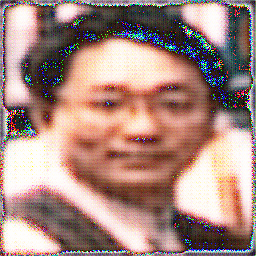

In [24]:
output_image

In [28]:
import torch
from torchvision import transforms
from PIL import Image

with torch.no_grad():
    # Perform translation
    output_tensor = cycle_gan.G_XtoY(input_tensor)  # Assuming you want to translate to domain Y

    # Squeeze the output tensor and move to CPU if necessary
    output_ts = output_tensor.squeeze().cuda()

    # Check tensor values
    print(f'Tensor min: {output_ts.min()}')
    print(f'Tensor max: {output_ts.max()}')
    print(f'Tensor mean: {output_ts.mean()}')
    print(f'Tensor shape: {output_ts.shape}')

    # Denormalize the tensor (assuming the model output is in the range [-1, 1])
    output_ts = (output_ts + 1) * 0.5

    # Optionally scale to [0, 255]
    output_ts = output_ts

    # Convert the tensor to a PIL image
    output_image = transforms.ToPILImage()(output_ts)

    # Display or save the translated image
    output_image.show()

    # Or save it to a file
    # output_image.save('/content/drive/MyDrive/deep_learning/translated_image4.png')
    output_image.save('_image4.png')


Tensor min: -0.985673189163208
Tensor max: 1.0
Tensor mean: 0.49471673369407654
Tensor shape: torch.Size([3, 256, 256])


In [26]:
output_ts

tensor([[[0.3133, 0.2014, 0.1756,  ..., 0.1501, 0.1834, 0.2653],
         [0.2351, 0.1084, 0.1756,  ..., 0.1009, 0.0691, 0.2784],
         [0.1071, 0.1714, 0.0491,  ..., 0.1698, 0.0378, 0.1565],
         ...,
         [0.1585, 0.7332, 0.1596,  ..., 0.0878, 0.0431, 0.2767],
         [0.1612, 0.4442, 0.1310,  ..., 0.1606, 0.0329, 0.1331],
         [0.2915, 0.3385, 0.1762,  ..., 0.1235, 0.1241, 0.2742]],

        [[0.4276, 0.1900, 0.1948,  ..., 0.2096, 0.1479, 0.3742],
         [0.1286, 0.0586, 0.0618,  ..., 0.0742, 0.0282, 0.1579],
         [0.2045, 0.0953, 0.0478,  ..., 0.0521, 0.0457, 0.2024],
         ...,
         [0.0979, 0.0479, 0.0072,  ..., 0.0681, 0.0172, 0.1532],
         [0.1084, 0.2490, 0.0360,  ..., 0.0229, 0.0314, 0.2292],
         [0.2010, 0.0866, 0.1094,  ..., 0.1380, 0.2169, 0.4726]],

        [[0.2275, 0.2352, 0.2732,  ..., 0.1550, 0.2830, 0.2769],
         [0.1426, 0.3875, 0.1402,  ..., 0.1068, 0.0953, 0.0924],
         [0.1765, 0.1789, 0.0854,  ..., 0.1586, 0.0521, 0.

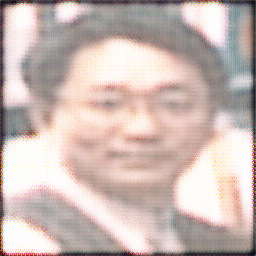

In [29]:
output_image